In [1]:
%load_ext autoreload
%autoreload 2
from bp import parse_newick, to_skbio_treenode, to_skbio_treearray
from skbio import TreeNode
import numpy as np
import glob
from functools import partial
from random import shuffle
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
def _correct_gg_reroot_length_issue(t):
    # the greengenes trees on reroot had a node with a length set to None
    # find and correct if it exists
    try:
        gg_reroot_none_node = t.find('k__Bacteria')
        gg_reroot_none_node.length = 0.0
    except:
        pass

    return t

def _bpshear(bpt, names_to_keep):
    # map the tips names to index positions in the bpt and shear/collapse
    bpt_tips = np.array([i for i, p in enumerate(bpt.B) 
                         if p and bpt.isleaf(i) and bpt.name(i) in names_to_keep], dtype=np.uint32)
    return bpt.shear(bpt_tips).collapse()

def shear_names(skt):
    # determine which tips to keep
    names = [n.name for n in skt.tips()]
    shuffle(names)
    to_keep = int(np.ceil(len(names) * 0.1))
    names_to_keep = set(names[:to_keep])
    return names_to_keep

def read_before_parse_newick(f):
    """we need to have newick in memory right now, so not a fair comparison if we cache"""
    return parse_newick(open(f).read())

In [21]:
timings = {}
for f in glob.glob('../../../greengenes_release/gg_13_8_otus/trees/*_otus.tree'):
    obs = {}
    key = f.rsplit('/')[-1]
    #if key.startswith('9') or key.startswith('8'):
    #    continue
    print(key)

    sk_parse = %timeit -o -q TreeNode.read(f)
    bp_parse = %timeit -o -q read_before_parse_newick(f)
    
    sktree = TreeNode.read(f)
    bptree = parse_newick(open(f).read())

    shear_names_to_keep = shear_names(sktree)
    sk_shear = %timeit -o -q sktree.shear(shear_names_to_keep)
    bp_shear = %timeit -o -q _bpshear(bptree, shear_names_to_keep)
    
    sk_toarray = %timeit -o -q sktree.to_array()
    bp_toarray = %timeit -o -q to_skbio_treearray(bptree)
    
    obs['n_tips'] = bptree.ntips()
    obs['sk_parse'] = sk_parse
    obs['bp_parse'] = bp_parse
    obs['sk_shear'] = sk_shear
    obs['bp_shear'] = bp_shear
    obs['sk_toarray'] = sk_toarray
    obs['bp_toarray'] = bp_toarray
    
    timings[key] = obs

61_otus.tree
64_otus.tree
67_otus.tree
70_otus.tree
73_otus.tree
76_otus.tree
79_otus.tree
82_otus.tree
85_otus.tree
88_otus.tree
91_otus.tree
94_otus.tree
97_otus.tree
99_otus.tree


<IPython.core.display.Javascript object>


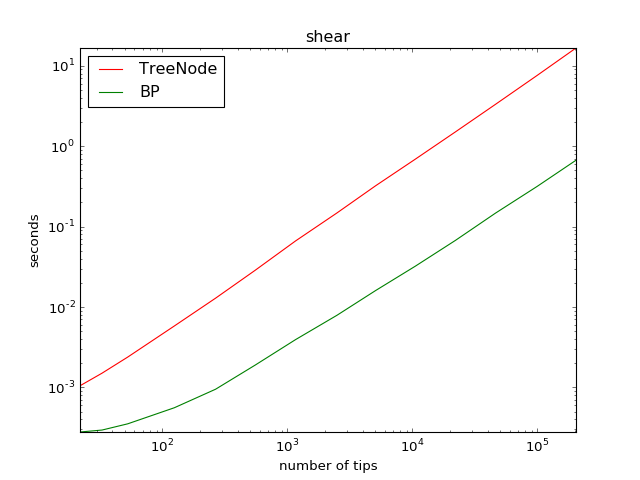

<IPython.core.display.Javascript object>


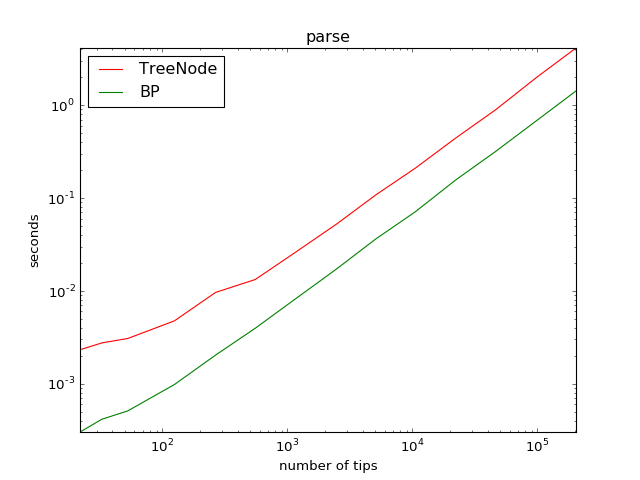

<IPython.core.display.Javascript object>


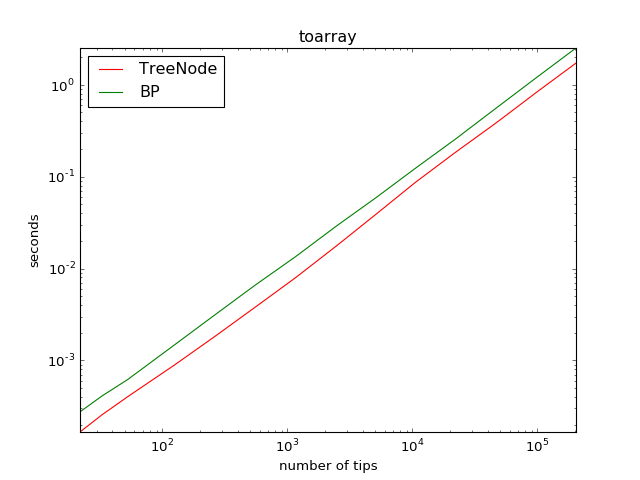

In [23]:
order = [f.rsplit('/')[-1] for f in glob.glob('../../../greengenes_release/gg_13_8_otus/trees/*_otus.tree')]
order = [o for o in order if o in timings]
xaxis = [timings[o]['n_tips'] for o in order]

for plot in ['shear', 'parse', 'toarray']:
    sktimes = []
    bptimes = []

    for o in order:
        sktimes.append(timings[o]['sk_%s' % plot].best)
        bptimes.append(timings[o]['bp_%s' % plot].best)

    fig = plt.figure()
    plt.plot(xaxis, sktimes, 'r')
    plt.plot(xaxis, bptimes, 'g')
    plt.title(plot)
    plt.xlim(min(xaxis), max(xaxis))
    plt.ylim(min(min(sktimes), min(bptimes)), max(max(sktimes), max(bptimes)))
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('number of tips')
    plt.ylabel('seconds')
    plt.legend(['TreeNode', 'BP'], loc=0)